In [ ]:
install.packages(c("caret", "tm", "SnowballC", "e1071", "randomForest"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘NLP’, ‘slam’, ‘BH’, ‘proxy’




In [ ]:
library(caret)
library(tm)
library(SnowballC)
library(e1071)
library(randomForest)
library(ggplot2)

Loading required package: ggplot2

Loading required package: lattice

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [ ]:
df <- read.csv("spam_balanced.csv", stringsAsFactors = FALSE)

In [ ]:
df$Category <- factor(df$Category, levels = c("ham", "spam"))


 ham spam 
4825 4825 


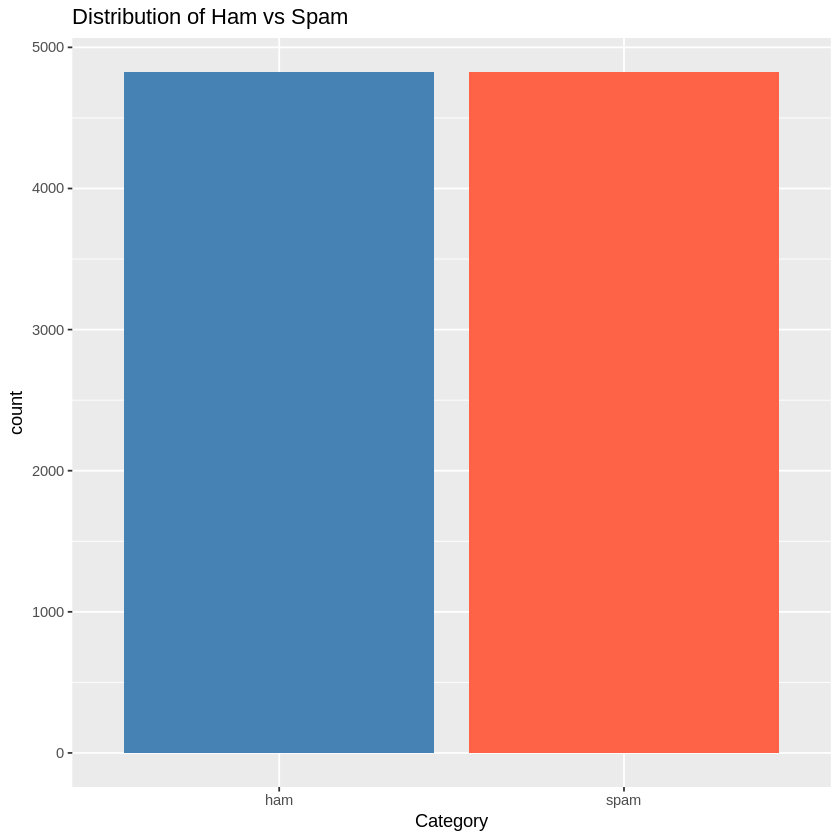

In [ ]:
# EDA: Check class distribution
print(table(df$Category))
ggplot(df, aes(x = Category)) +
  geom_bar(fill = c("steelblue", "tomato")) +
  labs(title = "Distribution of Ham vs Spam")

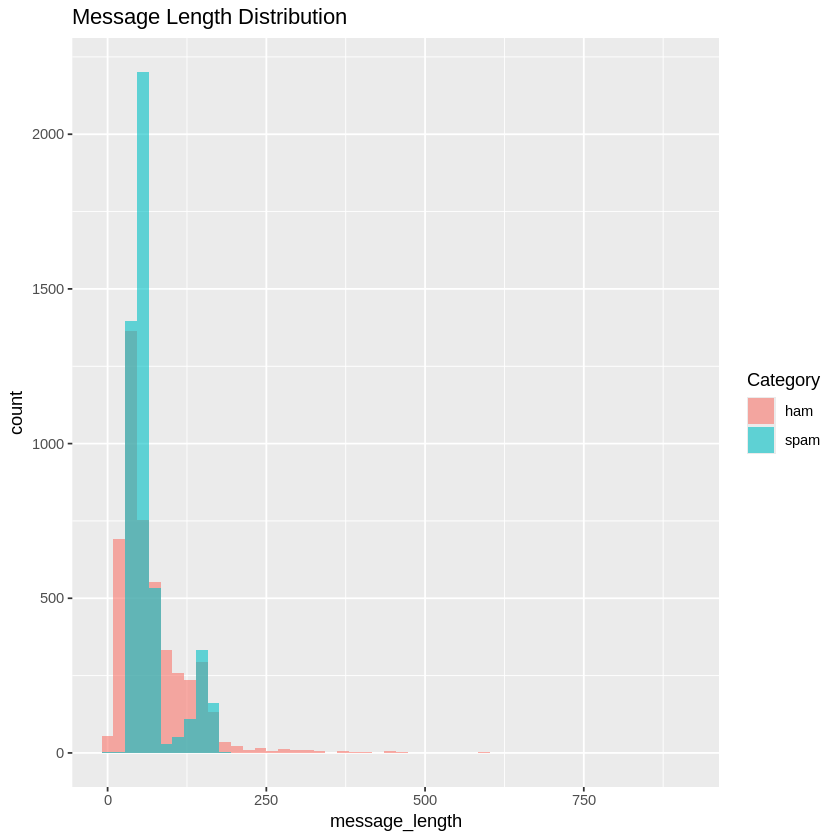

In [ ]:
# Add message length and plot
df$message_length <- nchar(df$Message)
ggplot(df, aes(x = message_length, fill = Category)) +
  geom_histogram(bins = 50, alpha = 0.6, position = "identity") +
  labs(title = "Message Length Distribution")

In [ ]:
# Text Preprocessing
corpus <- VCorpus(VectorSource(df$Message))
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeWords, stopwords("english"))
corpus <- tm_map(corpus, stripWhitespace)
corpus <- tm_map(corpus, stemDocument)

# Create TF-IDF matrix
dtm <- DocumentTermMatrix(corpus, control = list(weighting = weightTfIdf, minDocFreq = 5, maxDocFreq = 0.95))
dtm_mat <- as.data.frame(as.matrix(dtm))
dtm_mat$Category <- df$Category

Warning message in weighting(x):
“empty document(s): 229 740 947 1004 1294 1377 1673 2782 2789 3446 4177 4248 4312 4538 4793 4854 4933 5120 5317 5529 5938 6163 6582 8089 8102 8200 8499 9077 9293 9337 9574”


In [ ]:
# Train/test split
set.seed(42)
trainIndex <- createDataPartition(dtm_mat$Category, p = 0.8, list = FALSE)
trainData <- dtm_mat[trainIndex, ]
testData <- dtm_mat[-trainIndex, ]

In [ ]:
svm_model <- svm(Category ~ ., data = trainData, class.weights = c(ham = 1, spam = 5))
svm_pred <- predict(svm_model, newdata = testData)

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘`£award`’ and ‘`£month`’ and ‘aaniy’ and ‘abroad’ and ‘absolut’ and ‘accordin’ and ‘accordinglyor’ and ‘accumul’ and ‘acknowledg’ and ‘acsmsreward’ and ‘addamsfa’ and ‘addict’ and ‘addressul’ and ‘adewal’ and ‘admit’ and ‘admiti’ and ‘affidavit’ and ‘againcal’ and ‘agalla’ and ‘ageppermesssubscript’ and ‘agesr’ and ‘ahhhhjust’ and ‘aka’ and ‘aldrin’ and ‘algorithm’ and ‘allahmeet’ and ‘allo’ and ‘alreadysabarish’ and ‘alrightokay’ and ‘alter’ and ‘amanda’ and ‘amor’ and ‘anal’ and ‘anetwork’ and ‘anni’ and ‘annoyin’ and ‘answerin’ and ‘anyhow’ and ‘anythi’ and ‘aom’ and ‘appi’ and ‘appledayno’ and ‘apr’ and ‘apt’ and ‘arithmet’ and ‘arm’ and ‘artist’ and ‘astound’ and ‘astrolog’ and ‘athlet’ and ‘attent’ and ‘australia’ and ‘authoris’ and ‘availa’ and ‘aveng’ and ‘`b‘ham`’ and ‘baaaaaaaab’ and ‘babygoodby’ and ‘babyjontet’ and ‘babysit’ and ‘baig’ and ‘bakra’ and ‘bam’ and ‘ban’ and ‘bandag’ 

In [ ]:
# Sanitize and de-duplicate column names
colnames(trainData) <- make.unique(make.names(colnames(trainData)))
colnames(testData) <- make.unique(make.names(colnames(testData)))

In [ ]:
install.packages("ranger")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’




In [ ]:
library(ranger)
rf_model <- ranger(Category ~ ., data = trainData, num.trees = 100)
rf_pred <- predict(rf_model, data = testData)$predictions


Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance




Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.


In [ ]:
evaluate <- function(true, pred, model) {
  cm <- confusionMatrix(pred, true, positive = "spam")
  data.frame(
    Model = model,
    Accuracy = cm$overall["Accuracy"],
    Precision = cm$byClass["Precision"],
    Recall = cm$byClass["Recall"],
    F1 = cm$byClass["F1"]
  )
}

In [ ]:
results <- rbind(
  evaluate(testData$Category, svm_pred, "SVM"),
  evaluate(testData$Category, rf_pred, "Random Forest")
)

print("Model Comparison:")
print(results)

[1] "Model Comparison:"
                  Model  Accuracy Precision    Recall        F1
Accuracy            SVM 0.5000000 0.5000000 1.0000000 0.6666667
Accuracy1 Random Forest 0.9860104 0.9978769 0.9740933 0.9858416


In [ ]:
library(recipes)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step




In [ ]:
predict_message <- function(model, new_messages, training_dtm) {
  # Create corpus from new messages
  new_corpus <- Corpus(VectorSource(new_messages))

  # Apply the same preprocessing as you did for training
  new_corpus <- tm_map(new_corpus, content_transformer(tolower))
  new_corpus <- tm_map(new_corpus, removePunctuation)
  new_corpus <- tm_map(new_corpus, removeNumbers)
  new_corpus <- tm_map(new_corpus, removeWords, stopwords("english"))
  new_corpus <- tm_map(new_corpus, stripWhitespace)

  # Create DTM with the SAME terms as in training
  new_dtm <- DocumentTermMatrix(new_corpus, control = list(dictionary = colnames(training_dtm)))

  # Convert to matrix for prediction
  new_dtm_mat <- as.matrix(new_dtm)

  # Make predictions based on model type
  if (inherits(model, "ranger") || inherits(model, "randomForest")) {
    # For Random Forest models, convert to data frame
    new_dtm_df <- as.data.frame(new_dtm_mat)

    model_colnames <- model$forest$independent.variable.names

    missing_cols <- setdiff(model_colnames, colnames(new_dtm_df))
    for (col in missing_cols) {
      new_dtm_df[[col]] <- 0
    }

    new_dtm_df <- new_dtm_df[, model_colnames, drop = FALSE]
    predictions <- predict(model, data = new_dtm_df)$predictions
  } else {
    predictions <- predict(model, new_dtm_mat)
  }

  return(predictions)
}

In [ ]:
sample_msgs <- c(
  "Congratulations! You've won a free ticket to Bahamas. Call now!",
  "Hi there, are we still meeting for lunch today?"
)

print("Sample Predictions (SVM):")
print(predict_message(svm_model, sample_msgs, dtm))  # Use training dtm

print("Sample Predictions (Random Forest):")
print(predict_message(rf_model, sample_msgs, dtm))

[1] "Sample Predictions (SVM):"


Warning message in tm_map.SimpleCorpus(new_corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, stripWhitespace):
“transformation drops documents”


   1    2 
spam spam 
Levels: ham spam
[1] "Sample Predictions (Random Forest):"


Warning message in tm_map.SimpleCorpus(new_corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(new_corpus, stripWhitespace):
“transformation drops documents”


[1] spam ham 
Levels: ham spam
